In [1]:
import pandas as pd
import numpy as np
import os

In [64]:
path = os.getcwd()
test = pd.read_csv(path+'\Quant_Public_Data_March\预测目标.测试集.csv')
train = pd.read_csv(path+'\Quant_Public_Data_March\预测目标.训练集.csv')
mkt_data = pd.read_csv(path+'\Quant_Public_Data_March\市场数据.训练集.日.csv')
fin_monthly_data = pd.read_csv(path+'\Quant_Public_Data_March\经济数据.训练集.月.csv')
fin_seasonly_data = pd.read_csv(path+'\Quant_Public_Data_March\经济数据.训练集.季.csv')
fin_yearly_data = pd.read_csv(path+'\Quant_Public_Data_March\经济数据.训练数据.年.csv')
fin_est_data = pd.read_csv(path+'\Quant_Public_Data_March\房地产数据.训练集.月.csv')

In [65]:
# 将非日数据转化为日数据
fin_est_data[['biz_date']] = fin_est_data['biz_month']+'-01'
#fin_yearly_data[['biz_year']] = fin_yearly_data['biz_year']+'-01-01'   类型不一致
fin_seasonly_data[['biz_date']] = fin_seasonly_data['biz_season']+'-01'
fin_monthly_data[['biz_date']] = fin_monthly_data['biz_month']+'-01'

del fin_est_data['biz_month']
del fin_seasonly_data['biz_season']
del fin_monthly_data['biz_month']

#先做cdb类型的
#cdb = [c for c in train.columns if 'cdb' in c]


# 所有字段拼接起来
train_data = pd.merge(pd.merge(pd.merge(pd.merge(train,mkt_data,on = ['biz_date'],how='outer'),
                                       fin_est_data,on = ['biz_date'],how='outer'),
                              fin_seasonly_data,on = ['biz_date'],how='outer'),
                     fin_monthly_data,on = ['biz_date'],how='outer')
#test_data.to_csv('test_data.csv',index=False,header=True) 

del train_data['Unnamed: 5']
#test_target = [c for c in train.columns if 'treasury_bond_rate_10y' in c]
target = [c for c in train_data.columns if 'treasury_bond_rate_10y' in c]
#feature = [c for c in train_data.columns if 'treasury_bond_rate_10y' not in c  and 'biz_date' not in c]
#train_data = train[target]


In [66]:
#train_data.iloc[0,4]>'2002-01-05'
train_data = train_data[train_data['biz_date']<='2021-02-18']
# train_data = train_data[train_data['biz_date']>='2010-01-01']
train_data = train_data[train_data['treasury_bond_rate_10y'].notna()]
train_data = train_data.fillna(0)
train_data = train_data.sort_values(by='biz_date') 
#train_data = pd.DataFrame(train_data,index=['biz_date'])
#train_data.to_csv('data.csv',index=False,header=True) 
train_data= train_data.set_index('biz_date')

In [67]:
# train_data.to_csv('data1.csv',index=True,header=True) 

In [69]:
# def sliceWindow(data,target,step): 
#     X,y=[],[]  
#     for i in range(0,len(np.array(data))-step,1):  
#         end=i+step       
#         oneX,oney=np.array(data)[i:end,:],np.array(data[target])[end, :]  
#         X.append(oneX)  
#         y.append(oney)  
#     return np.array(X),np.array(y)  

def sliceWindow(data,target,step): 
    X,y=[],[]  
    for i in range(0,len(np.array(data))-2*step,1):  
        end=i+step       
        oneX,oney=np.array(data)[i:end,:],np.array(data[target])[end:end+step, :]  
        X.append(oneX)  
        y.append(oney)  
    return np.array(X),np.array(y)  



In [70]:
def dataSplit(dataset,target,step,ratio=0.70):  
    datasetX,datasetY=sliceWindow(dataset,target,step)  
    train_size=int(len(datasetX)*ratio)  
    X_train,y_train=datasetX[0:train_size,:],datasetY[0:train_size,:] 
    X_test,y_test=datasetX[train_size:len(datasetX),:],datasetY[train_size:len(datasetX),:]  
    X_train=X_train.reshape(X_train.shape[0],step,-1)  
    X_test=X_test.reshape(X_test.shape[0],step,-1)
    y_train = y_train.reshape(y_train.shape[0],step,-1)
    y_test = y_test.reshape(y_test.shape[0],step,-1)
    print('X_train.shape: ',X_train.shape)  
    print('X_test.shape: ',X_test.shape)  
    print('y_train.shape: ',y_train.shape)  
    print('y_test.shape: ',y_test.shape)  
    return X_train,X_test,y_train,y_test  

In [71]:
from sklearn import preprocessing
#train_data = pd.DataFrame(preprocessing.scale(train_data),columns = train_data.columns)
X_train,X_test,y_train,y_test  = dataSplit(train_data,target,step=30)

X_train.shape:  (3301, 30, 44)
X_test.shape:  (1416, 30, 44)
y_train.shape:  (3301, 30, 1)
y_test.shape:  (1416, 30, 1)


In [72]:
# 创建模型
from keras.models import Sequential
from keras.layers import Dense, Activation,LSTM,Dropout
from keras.optimizers import Adam

model = Sequential()

model.add(LSTM(128, input_shape=(X_train.shape[1],X_train.shape[2]),activation='sigmoid', return_sequences=True, dropout=0.1))
model.add(LSTM(256, activation='sigmoid', return_sequences=True, dropout=0.01))
model.add(Dropout(rate=0.1))
model.add(LSTM(128, activation='sigmoid', dropout=0.2))
model.add(Dense(y_train.shape[1]))
model.compile(loss='mae', optimizer=Adam(lr=0.002, decay=0.01))

print(model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 30, 128)           88576     
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 256)           394240    
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                3870      
Total params: 683,806
Trainable params: 683,806
Non-trainable params: 0
_________________________________________________________________
None


In [85]:
# 训练模型
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
history = model.fit(X_train, y_train, epochs=1, batch_size=200, validation_data=(X_test, y_test), shuffle=False)


17/17 [==============================] - 17s 1s/step - loss: 0.4943 - val_loss: 0.3318


In [19]:
model.save("model1.h5")

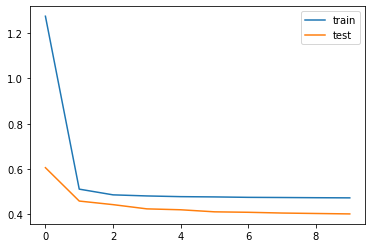

In [74]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [14]:
# def predictFuture(model,dataset,features,step,next_num):
#     lastOne=(dataset[len(dataset)-step:len(dataset)]).reshape(-1,features) 
#     backData=lastOne.tolist()
#     next_predicted_list=[]
#     for i in range(next_num): 
#         one_next=backData[len(backData)-step:] 
#         one_next=np.array(one_next).reshape(1,step,features) 
#         next_predicted=model.predict([one_next]) 
#         next_predicted_list.append(next_predicted[0].tolist()) 
#         backData.append(next_predicted[0]) 
#     return next_predicted_list 


In [86]:
pre_train = np.array(train_data.tail(30))

In [87]:
pre_train = pre_train.reshape(1,30,44)  

In [88]:

y_pre=model.predict(pre_train,verbose=0)

In [89]:
y_pre

array([[3.3936722, 3.3921669, 3.3897362, 3.3928425, 3.3945513, 3.3973985,
        3.3988185, 3.3996155, 3.4011388, 3.40076  , 3.4017057, 3.4057794,
        3.4040484, 3.4089804, 3.3954327, 3.4369617, 3.4359925, 3.452488 ,
        3.444436 , 3.4439812, 3.436712 , 3.4196754, 3.4127376, 3.4480426,
        3.4485695, 3.4513624, 3.4541104, 3.4549499, 3.451563 , 3.4150825]],
      dtype=float32)

In [45]:
pre_train

array([[[1.5995, 2.1518, 2.3646, ..., 0.    , 0.    , 0.    ],
        [1.5995, 2.1029, 2.3465, ..., 0.    , 0.    , 0.    ],
        [1.4967, 2.0034, 2.2397, ..., 0.    , 0.    , 0.    ],
        ...,
        [2.0325, 2.2999, 2.3663, ..., 0.    , 0.    , 0.    ],
        [1.8575, 2.21  , 2.3663, ..., 0.    , 0.    , 0.    ],
        [1.9075, 2.1056, 2.3802, ..., 0.    , 0.    , 0.    ]]])